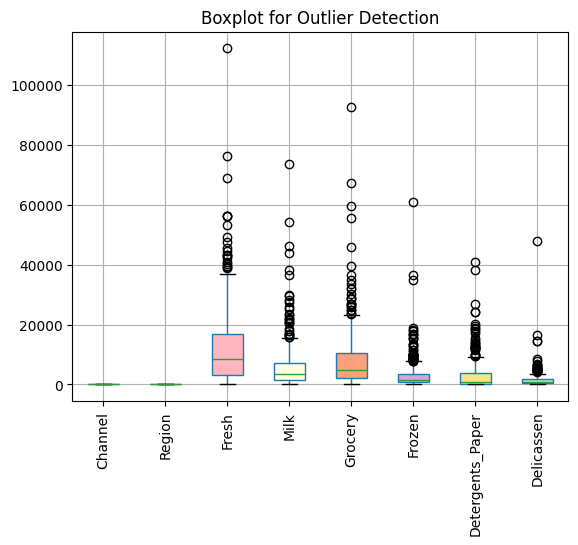

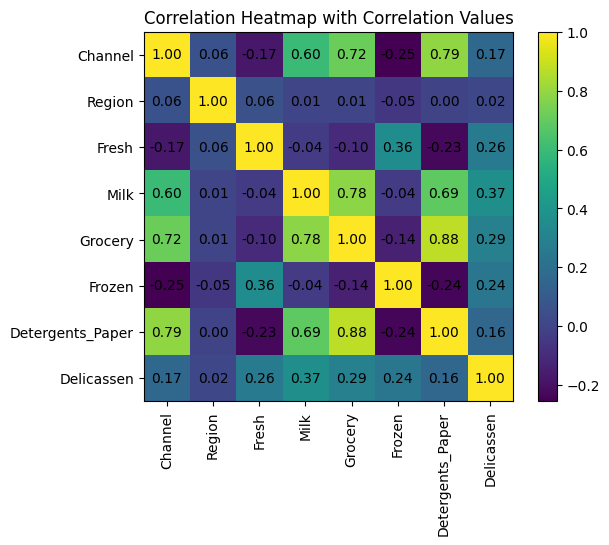

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------

df = pd.read_csv("ML470_S8_Wholesale Customers data_Practice.csv")

num_df = df.select_dtypes(include="number").round(2)

# -------------------------------
# Boxplot with Colors
# -------------------------------

def plot_colored_boxplots(data):
    plt.figure()

    box = data.boxplot(patch_artist=True)

    colors = ['lightblue', 'lightgreen', 'lightpink',
              'lightyellow', 'lightsalmon', 'plum',
              'khaki', 'lightgray']

    boxes = [patch for patch in box.patches if type(patch).__name__ == 'PathPatch']
    for patch, color in zip(boxes, colors):
        patch.set_facecolor(color)

    plt.title("Boxplot for Outlier Detection")
    plt.xticks(rotation=90)
    plt.show()

plot_colored_boxplots(num_df)

# -------------------------------
# IQR Outlier Treatment
# -------------------------------

def treat_outliers_iqr(df):
    df_out = df.copy()

    for col in df_out.columns:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        df_out[col] = np.where(
            df_out[col] < lower, lower,
            np.where(df_out[col] > upper, upper, df_out[col])
        )

    return df_out.round(2)

treated_df = treat_outliers_iqr(num_df)

# -------------------------------
# Correlation Heatmap with Values
# -------------------------------

def plot_correlation_heatmap(data):
    corr = data.corr()

    plt.figure()
    plt.imshow(corr)
    plt.colorbar()

    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)

    # add numbers inside boxes
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            plt.text(j, i, f"{corr.iloc[i, j]:.2f}",
                     ha="center", va="center")

    plt.title("Correlation Heatmap with Correlation Values")
    plt.show()

plot_correlation_heatmap(treated_df)

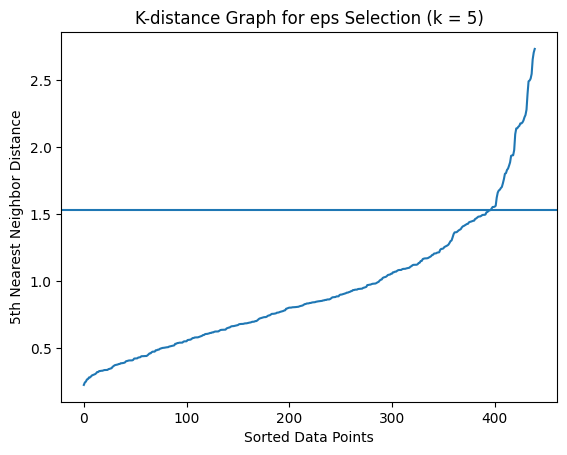

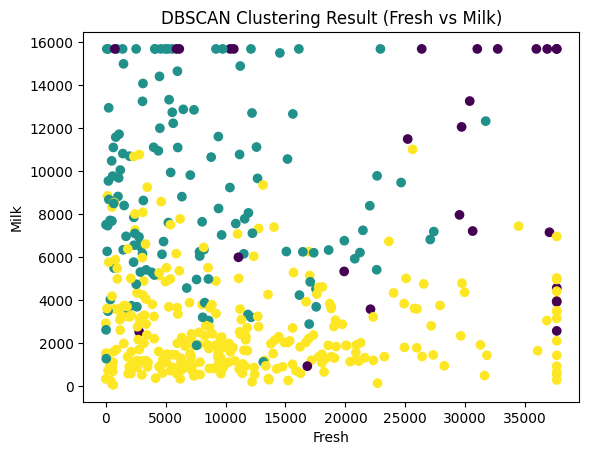

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

num_df = df.select_dtypes(include="number").round(2)

# -----------------------------------
# IQR-based Outlier Treatment
# -----------------------------------
def treat_outliers_iqr(df):
    df_out = df.copy()
    for col in df_out.columns:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        df_out[col] = np.where(
            df_out[col] < lower, lower,
            np.where(df_out[col] > upper, upper, df_out[col])
        )
    return df_out.round(2)

df_out = treat_outliers_iqr(num_df)

# -----------------------------------
# Remove highly correlated features
# -----------------------------------
corr = df_out.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] >= 0.7)]

df_reduced = df_out.drop(columns=to_drop)

# -----------------------------------
# Standardization
# -----------------------------------
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_reduced)

# =====================================================
# Visualization 1 — K-distance Graph (eps selection)
# =====================================================

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)

# 5th nearest neighbor distances
k_distances = np.sort(distances[:, 4])

plt.figure()
plt.plot(k_distances)
plt.axhline(y=np.percentile(k_distances, 90))
plt.title("K-distance Graph for eps Selection (k = 5)")
plt.xlabel("Sorted Data Points")
plt.ylabel("5th Nearest Neighbor Distance")
plt.show()

# choose eps from elbow (approx)
eps_value = np.percentile(k_distances, 90)

# =====================================================
# Visualization 2 — DBSCAN Clustering
# =====================================================

dbscan = DBSCAN(eps=eps_value, min_samples=5)
clusters = dbscan.fit_predict(scaled_data)

plt.figure()
plt.scatter(
    df_reduced["Fresh"],
    df_reduced["Milk"],
    c=clusters
)
plt.title("DBSCAN Clustering Result (Fresh vs Milk)")
plt.xlabel("Fresh")
plt.ylabel("Milk")
plt.show()

cluster
 1    288
 0    138
-1     14
Name: count, dtype: int64


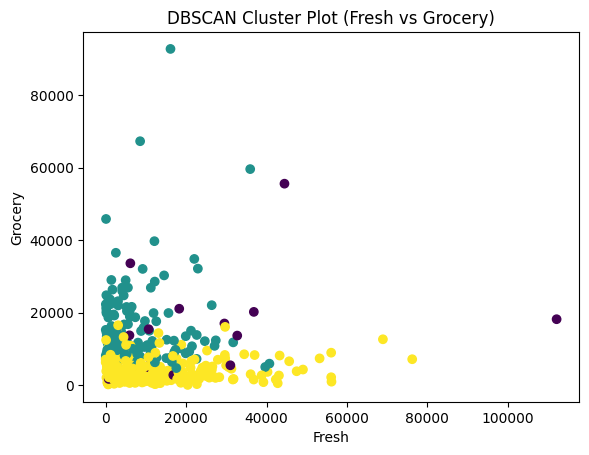

In [8]:
num_df = df.select_dtypes(include="number").round(2)

# -------------------------------
# IQR-based Outlier Treatment
# -------------------------------
def treat_outliers_iqr(df):
    df_out = df.copy()
    for col in df_out.columns:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        df_out[col] = np.where(
            df_out[col] < lower, lower,
            np.where(df_out[col] > upper, upper, df_out[col])
        )
    return df_out.round(2)

df_out = treat_outliers_iqr(num_df)

# -------------------------------
# Remove multicollinear feature
# -------------------------------
df_out = df_out.drop(columns=["Detergents_Paper"], errors="ignore")

# -------------------------------
# Scaling
# -------------------------------
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_out)

# -------------------------------
# 2. Apply DBSCAN
# -------------------------------
dbscan = DBSCAN(eps=2, min_samples=5)
clusters = dbscan.fit_predict(scaled_data)

# Add cluster labels to original dataframe
df["cluster"] = clusters

# -------------------------------
# Cluster Count Summary
# -------------------------------
print(df["cluster"].value_counts())

# -------------------------------
# 3. DBSCAN Cluster Plot
# -------------------------------
plt.figure()
plt.scatter(
    df["Fresh"],
    df["Grocery"],
    c=df["cluster"]
)
plt.xlabel("Fresh")
plt.ylabel("Grocery")
plt.title("DBSCAN Cluster Plot (Fresh vs Grocery)")
plt.show()